# Lab part 2 Improving the models

By Ebba Bergman, 2023

## Note on Questions
In this notebook you will try several things, some of them might be new to you. Try to understand what the new techniques could improve in each case. Reflect to see if you can see these improvements and if not think about why. I might add additional questions, but always keep in mind: **What** then **How** and always, always ***Why***

Stop the kernel of your other notebooks while you run this one. 

## Brief
Your main task in this lab is to make a network that can categorise bloodcells from the  [Human White Blood Cells (BBBC045v1)](https://bbbc.broadinstitute.org/BBBC045) dataset from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]. 

In the first part of this lab you got some networks to try. In this part we will explore some new techniques that you will apply to try and improve this network.  

*Note: It's not always easy to know from the start what will work, a lot of developing neural networks can feel like qualified guess work. **Qualified** being the key word.*

Also take this opportunity to try to understand the code, you may be able to reuse some of it for your assignment in Deep Learning. There will be questions throughout to give you things to consider, but **no hand in is required**. 


### Story
You are working at BestEverLifeScienceCompany, or BELSC, and your boss was recently handed some blood cell data. You've managed to classify the blood cells, finding the CNN model to be the most useful. You ran into your boss in the corridor, who's thrilled it's possible to do this (which you already knew) but your boss isn't entirely happy wiht the results and wants you to improve the networks to a 99% accuracy.

You wisely tell your boss that you cannot guarantee any accuracy, but that you can use some methods to try and improve the results so that your boss can show your bosses boss that there's hope for this project on their next meeting on Tuesday. Thankfully your boss cancel all your future meetings together so you can focus on this task. So one, they cancelled one meeting. 

If you finish quickly your boss has some other datasets that need your attention, and the corporate conference is on Tuesday the 16th of May so all results need to be done by the 15th of May. 

You promise to do as much as you can, and your boss makes sure that you know that the first dataset definetly needs to be done, but the other one could earn both of you bonus points before the final evaluation of this season.

### So
1. finish this lab and make sure you understand it (*you will need this information at some point*)
2. Once you're done start on the assignment

#### Credit
A lot of the code below is inspired by https://www.tensorflow.org/guide/keras/functional/,  and labs developed by Christophe Avenel at NBIS, the cnn_helper is from there though adjusted by me. The lab is also partly built on Phil Harrison's lab for the pharmaceutical bioinformatics and sequence analysis course.

The questions and tasks were designed by Ebba Bergman for Big Data in Life Sciences

# Import

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cnn_helper
import plot_helper

# Settings 

In [ ]:
## Set up where to find our data
data_directory = "./data/BloodCells/bloodcells_small/data/"
labels_path =  "./data/BloodCells/bloodcells_small/labels.csv"

# Functions

Don't worry about the functions, they'll make more sense later. Just keep moving along.

In [ ]:
def start_time():
    print("Starting run at: " + str(datetime.now()))

def end_time():
    print("Run finished at: " + str(datetime.now()))
    
def get_image_data_flat_from_file(data_directory, image_paths):
    file_names = image_paths.values.flatten() # Assumes image_paths come in df[image_path_column_name] structure due to lab
    image_data = np.array([np.array(cv2.imread(data_directory + file_name)) for file_name in file_names])
    flattened_image_data = image_data.reshape(image_data.shape[0], -1)
    return flattened_image_data

# Data

In [ ]:
df_labels = pd.read_csv(labels_path)

In [ ]:
## Next, let's divide the filtered rows into a train, validation and a test set. 
class_column_header = "Class"
df_labels_to_use = df_labels.copy() #We're copying the df_labels so that you can look at the original again later if you want

test_set_fraction = 0.1
validation_set_fraction = 0.2

In [ ]:
df_test = df_labels_to_use.groupby(class_column_header).sample(frac = test_set_fraction)
df_to_use = pd.concat([df_labels_to_use, df_test, df_test]).drop_duplicates(keep=False) # This line finds the intersection between df_filtered and df_test and df_test and dropps anything that belongs to two of those, so we are left with df_train. Using only df_test once should be fine, but better safe than sorry
df_validation = df_labels_to_use.groupby(class_column_header).sample(frac = validation_set_fraction)
df_train = pd.concat([df_labels_to_use, df_validation, df_validation]).drop_duplicates(keep=False) 

Let's load and then look at the labels and our data.

In [ ]:
print(df_test.head())

In [ ]:
df_labels = pd.read_csv(labels_path) 

In [ ]:
df_labels.head()

In [ ]:
df_labels.shape

### Q: Look at the labels, which column do you think contains the true label? Hint: it's probably the same as in part1

## Data Augmentation


Let's try to improve the network. One thing that is often done for CNNs and other NNs is data agumentation. Data augmentation basically means that we randomly alter the incoming images in different ways to make sure that the network can handle those types of variations.

If you want to read more you can look at this article, especially the "Data Augmentations based on basic image manipulations Geometric transformations" is of interest here: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for things you can try by adding input paramters to the ImageDataGenerator().


Update the cell below to  **include data augmentations, only in the training data generator then retrain the best version of your CNN again**

In [ ]:
## Set up generators 

image_shape = (32,32)
filename_column = 'Filenames'
true_value = "Class"

# Hyper parameters
batch_size = 8


# create a data generator


## Note: we tend to get better results if the values of the pixels are between 0 and 1, so we need a rescale of 1/255 since the highest possible pixel value for these images are 255
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_validation, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps=train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps=valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1


In [ ]:
## Set up the model architecture
### use your best model from part 1, and rename it here to cnn_model_augmented
## Then run the model
## Then plot the results and show a confusion matrix

### Q: Did the data augmentation help? Why or why not? What makes this dataset more or less likely to be helped by data augmentation?




<details>
<summary>
<font size="3" color="green">
<b>Teacher thoughts <code><font size="4"> Some things to consider</font></code></b>
</font>
</summary>

1. Are the blood cells at random places in the image?
    
2. Are the blood cells within one class of different sizes?
    
3. Are there color changes you could compensate for? 

4. Are the blood cells symetrical? In what ways are they (not) symmetrical?

Note: Reflect on which of these you tried to adjust for in your code above.


</details>


## Regularisation methods


Both BatchNormalization and DropOut are two different regularisation methods. Try adding both to the best working CNN model without data augmentation
  
Read more about BatchNormalization here: https://keras.io/api/layers/normalization_layers/batch_normalization/
Read more about DropOut here:https://keras.io/api/layers/regularization_layers/dropout/

### Q:  What are the main similarities and differences between these methods?
Batch Normalization actually caps the values based on all of the values, also present during validation and test but then with settings found during training.  
Dropout is only used during training, drops nodes from the network by random  
Both are regularization methods and good to use to prevent overfitting

  **Not using any other improvement methods, try both batch normalization and dropout individually**

### Q: Is there such a thing as too much regularisation?

# Visualise a layer in your best CNN

### Q: What can you understand from just looking at these weights?

# Using existing models 

One great thing to do when making a CNN model is to use an architecture that has worked for simmilar cases. I happen to know that the existing CNN model VGG16 is a good model for these types of images, try that one next.

There are many way of visualising neural networks, see https://datascience.stackexchange.com/questions/12851/how-do-you-visualize-neural-network-architectures, but here is one for VGG16

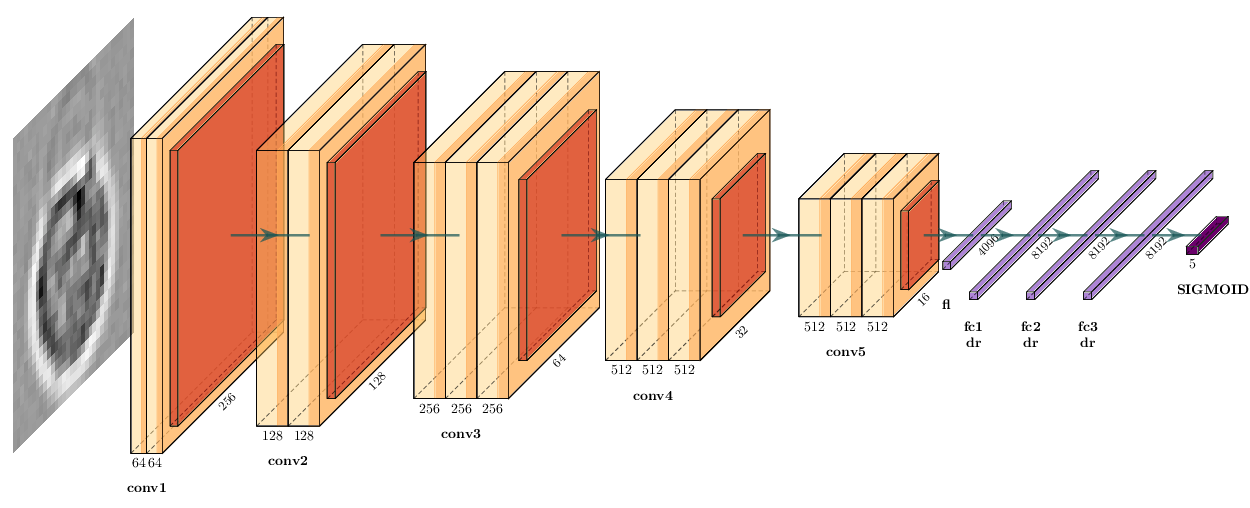

### VGG16

In [ ]:
vgg_model = keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=(32, 32, 1),
    pooling=None,
)

In [ ]:
# add new classifier layers
flat1 = layers.Flatten()(vgg_model.layers[-1].output) 
class1 = layers.Dense(1024, activation='relu')(flat1)
output = layers.Dense(5, activation='softmax')(class1)

### Q: Why did we do *vgg_model.layers[-1].output* ?

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">question above</font></code></b>
</font>
</summary>
1. What is the original network classifying? 

2. What do we want to classify? 



<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">The hint, if you need it</font></code></b>
</font>
</summary>
1. So how do we remove the previous classification and make the new one? Just like the code above naturally! A flattening layer is almost always followed by a dense layer or two to expand the model, and in a classification model the last layer is always the classification layer.


</details>
</details>

In [ ]:
vgg_model = keras.Model(inputs=vgg_model.inputs, outputs=output)

print (vgg_model.summary())

### Q: How many parameters does this model have?

In [ ]:
## Compile the model

vgg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
## Actually train model
epochs = 10
history = vgg_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

In [ ]:
## Plot results
plot_helper.plot_history(history, "VGG16")

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(vgg_model, valid_generator)

### Q: What is your worst performing class in this classifier? Is it the same as in the other models?
### Q: Is the VGG 16 outperforming your previous models? What are you looking at to determine this?
### Q: Is there any other metric you would prefer to use for this model?

# Finally test your best model

### Q: How is your test set performing compared to your training and validation sets? Why?

  
  
  
## The lab is done! Good job getting this far, and understanding what you are doing!  

## Now you have the opportunity to look at some other interesting things or to move on to the assignment. Use your time wisely!
    
    

# Optional

Try other optimizers, activation functions, learning rates, batch sizes or number of epochs. Which would you like to try first and why?

## Optional

Try using different proportions for training, validation and test. How does this affect your results? Why?

# Optional

Try and make a neural network with no convolutions that perform as well as the VGG16.

## Hints about Jupyter notebooks

#### HINT: You can comment out a whole cell by selecting all and then do ctr + / or cmnd + / 
#### You can then add another cell with the + button next to the save button at the top of this notebook's tool bar.
#### You can of course also keep adding cells and copying all the relevant code, making and saving new models. Whatever is easiest for you is best here.